<a href="https://colab.research.google.com/github/LoSgu8/traceroute_visualizer/blob/main/traceroute_visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas
!pip install --pre scapy[basic]
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.0 MB/s 
     |████████████████████████████████| 16.7 MB 359 kB/s 
     |████████████████████████████████| 6.3 MB 33.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 6.7 MB/s 
     |████████████████████████████████| 1.6 MB 38.2 MB/s 
  Created wheel for scapy: filename=scapy-2.5.0rc2-py2.py3-none-any.whl size=1439493 sha256=4998fa98880a803f69692ea4d5321779dd48842491bbf49533928996cef40b0c
  Stored in directory: /root/.cache/pip/wheels/c9/6f/72/6b47f9ac4ab18f234d89f1e28971ab9d4923698079c326c841
Successfully built scapy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import socket
from scapy.all import *
import ipaddress
import urllib.request
import json

In [3]:
# Get my coordinates based on IP address
my_ip = urllib.request.urlopen('https://api.ipify.org').read().decode('UTF-8')

my_ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + my_ip).read())

print(my_ip_info['city'] + ',' + my_ip_info['country']+' at ['+str(my_ip_info['lat'])+', '+str(my_ip_info['lon'])+']')

Las Vegas,United States at [36.1699, -115.1398]


In [4]:
hostname = "ftp.au.debian.org"
target_ip = socket.gethostbyname(hostname)
max_ttl = 30

ip_hops = []

# append my IP
ip_hops.append(my_ip)

#then append all the hops until the destination is reached
for i in range(max_ttl):
  packet = IP(dst = target_ip, ttl=i+1) / ICMP(seq = i)
  ans, unans = sr(packet, verbose = False, timeout = 5)
  if len(ans)>0:
    query = ans[0][0]
    answer = ans[0][1]
    if ipaddress.ip_address(answer.src).is_private != True:
      ip_hops.append(answer.src)
    if answer.src == target_ip:
      break;

In [5]:
ip_hops

['34.125.149.139',
 '138.44.10.40',
 '113.197.15.11',
 '138.44.161.3',
 '150.203.201.5',
 '150.203.201.13',
 '103.84.224.37']

In [7]:
hopInfo = pd.DataFrame(columns=['org', 'city', 'regionName', 'country', 'lat', 'lon'])
for ip in ip_hops:
  ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + ip).read())
  hopInfo = hopInfo.append({field: ip_info[field] for field in ('org', 'city', 'regionName', 'country', 'lat', 'lon')}, ignore_index = True)

In [8]:
hopInfo

,org,city,regionName,country,lat,lon
0,Google Cloud (us-west4),Las Vegas,Nevada,United States,36.1699,-115.1398
1,Australian Academic and Research Network,Sydney,New South Wales,Australia,-33.8715,151.2006
2,AARNet Pty Ltd,Burwood,Victoria,Australia,-37.8494,145.1127
3,Australian Academic and Research Network,Canberra,Australian Capital Territory,Australia,-35.3122,149.1511
4,Iasanu,Canberra,Australian Capital Territory,Australia,-35.2828,149.1283
5,Iasanu,Canberra,Australian Capital Territory,Australia,-35.2828,149.1283
6,Linux Australia Inc,Sydney,New South Wales,Australia,-33.8688,151.2090


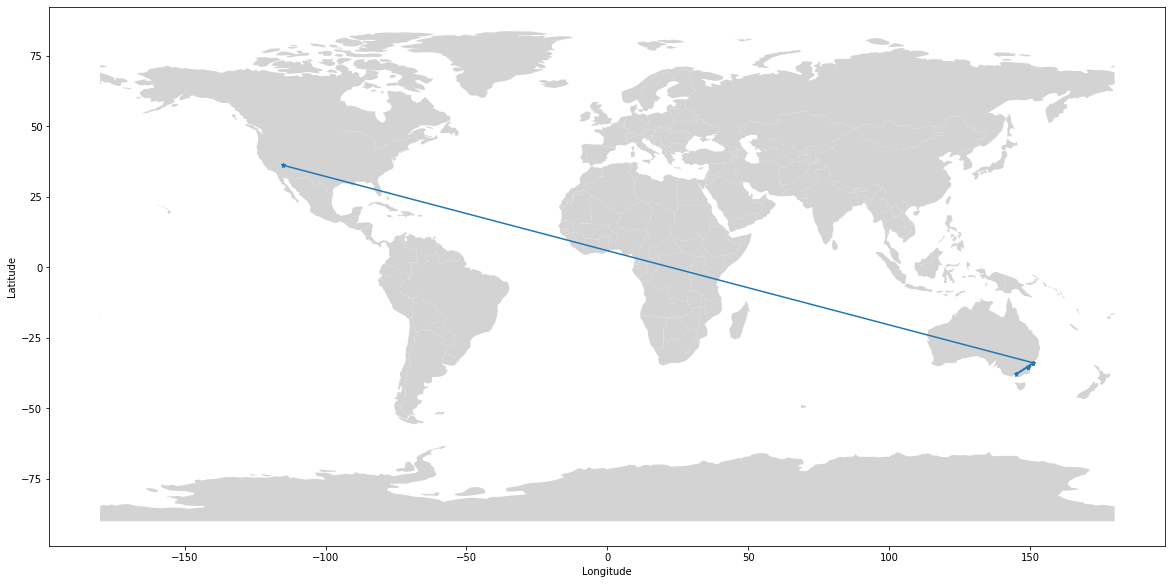

In [9]:
fig, ax = plt.subplots(figsize=(20,15))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.plot(color="lightgrey", ax=ax)

hopInfo.plot(x="lon", y="lat", xlabel="Longitude", ylabel="Latitude", ax=ax, marker="*", markersize=5, legend=False);